# Currency exchange example

Dataset used is the currency enchange with respect to USD dollars, from daily measurements from the last 2 years (2017-2018).

Currencies used: 
- Reference: USA
- Canadian dollar (CAD)
- Euro (EUR)
- Japanese yen (JPY)
- Great british pound (GBP)
- Swiss franc (CHF)
- Austrial dollar (AUD)
- Hong Kong dollar (HKD)
- New zealand dollar (NZD)
- South korean won (KRW)
- Mexican peso (MXN)

Please see our publication at https://doi.org/10.1109/ICASSP40776.2020.9054102 for a full description of this data set and the interpretations of our results.

In [1]:
import mogptk
import numpy as np
import pandas as pd

## Data loading

In [2]:
column_names = ['EUR/USD', 'CAD/USD', 'JPY/USD', 'GBP/USD', 'CHF/USD',
                'AUD/USD', 'HKD/USD','NZD/USD', 'KRW/USD','MXN/USD']

dataset = mogptk.DataSet()
for names in column_names:
    dataset.append(mogptk.LoadCSV('data/currency_exchange/final_dataset.csv',
                                    x_col='Date', y_col=names))

dataset.filter('2017-01-03', '2018-01-01')

In [3]:
# Preprocess by randomly removing points and detrending
for i, channel in enumerate(dataset):
    channel.transform(mogptk.TransformDetrend)
    channel.transform(mogptk.TransformNormalize())
    channel.remove_randomly(pct=0.3)
    
    if i not in [0, 2, 5]:
        channel.remove_range('2017-11-17', None)
    
# simulate sensor failure
dataset[1].remove_range('2017-03-31', '2017-05-01')
dataset[2].remove_range('2017-12-28', None)
dataset[3].remove_range('2017-07-20', '2017-09-08')
dataset[4].remove_range(None, '2017-01-31')
dataset[5].remove_range('2017-12-28', None)
dataset[7].remove_range(None, '2017-01-31')

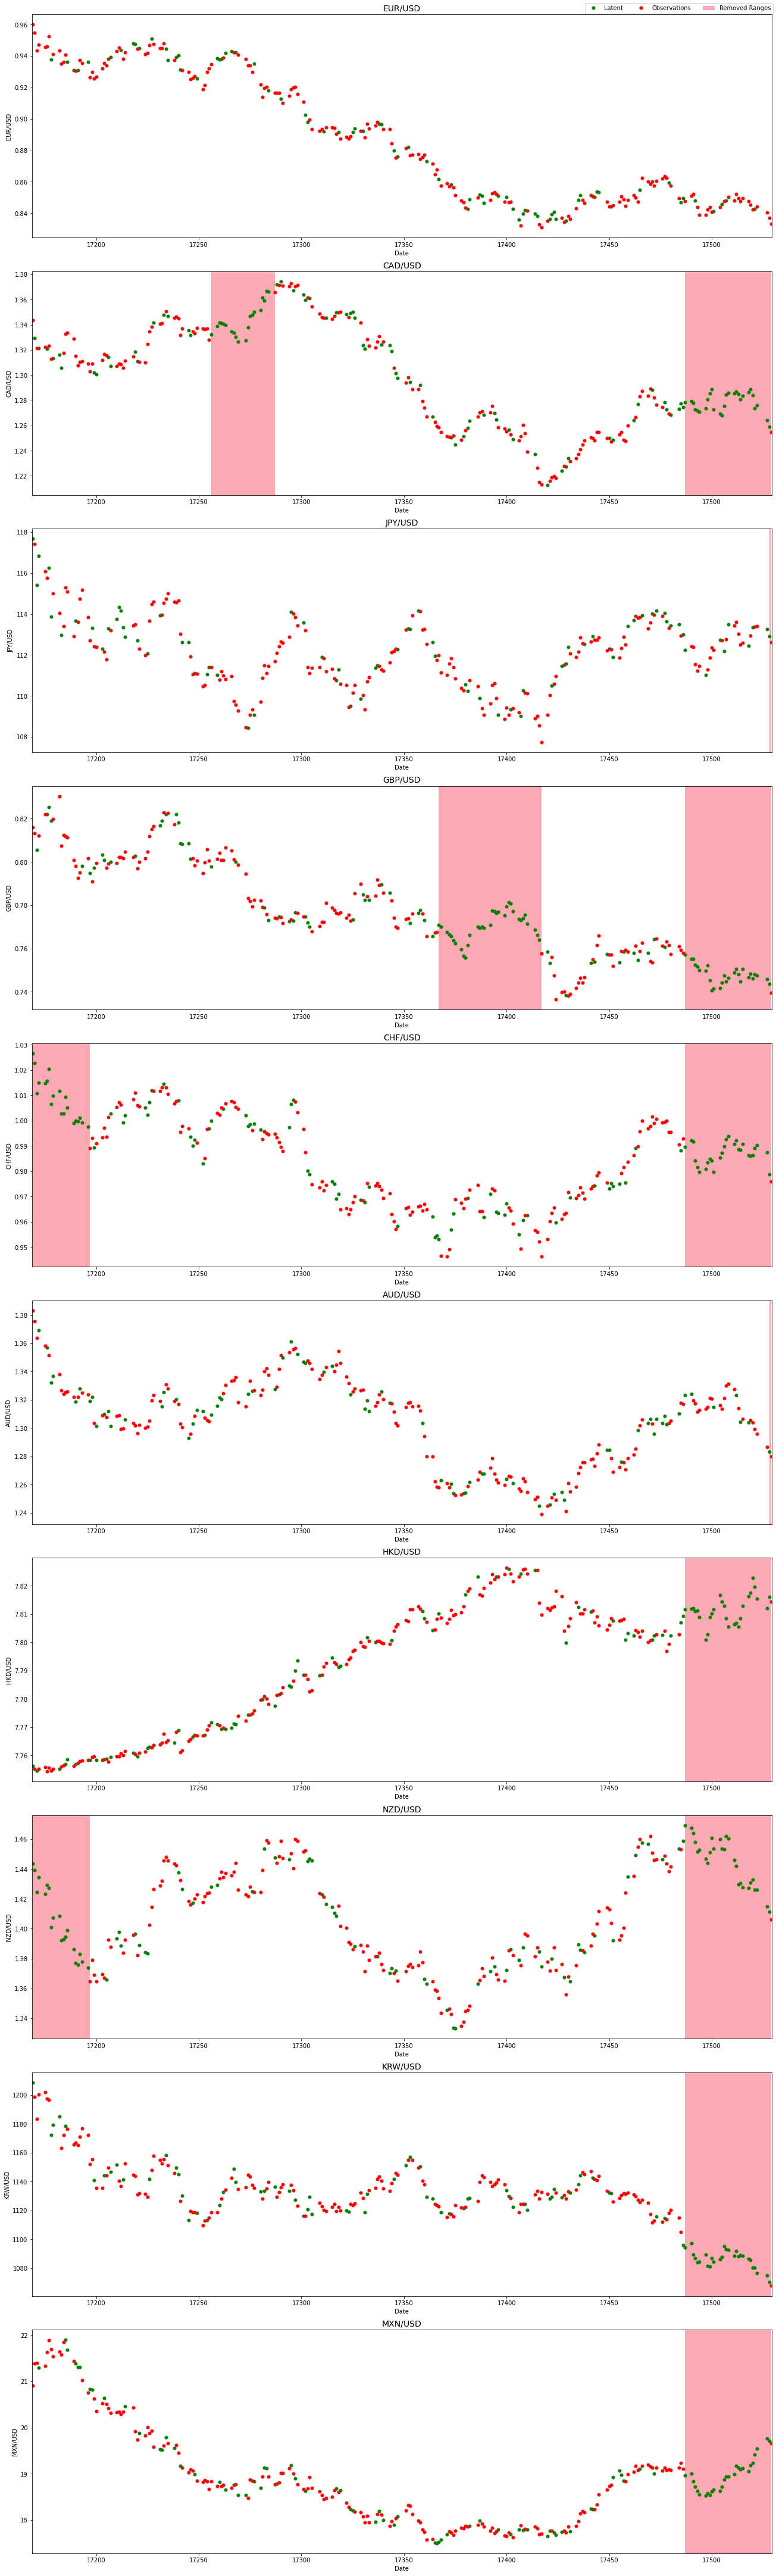

In [4]:
dataset.plot();

In [5]:
n_trials = 3
Q = 3
init_method = 'BNSE'
method = 'Adam'
lr = 0.2
iters = 500

## Multi-output spectral mixture kernel

In [6]:
mosm_models = []
mosm_mae = np.zeros((n_trials,10))
mosm_rmse = np.zeros((n_trials,10))
mosm_mape = np.zeros((n_trials,10))

# experiment trials
for n in range(n_trials):
    mosm_dataset = dataset.copy()
    for i, channel in enumerate(mosm_dataset):
        channel.remove_randomly(pct=0.3)
        
    print('\nTrial', n+1, 'of', n_trials)
    mosm = mogptk.MOSM(mosm_dataset, Q=Q)
    mosm.init_parameters(init_method)
    mosm.train(method=method, lr=lr, iters=iters, verbose=True)
    mosm_models.append(mosm)
    print('=' * 50)
    
    error = mogptk.error(mosm, per_channel=True)[0]
    mosm_mae[n,:] = np.array([item['MAE'] for item in error])
    mosm_rmse[n,:] = np.array([item['RMSE'] for item in error])
    mosm_mape[n,:] = np.array([item['MAPE'] for item in error])


Trial 1 of 3

Starting optimization using Adam
‣ Model: MOSM
‣ Channels: 10
‣ Parameters: 160
‣ Training points: 1089
‣ Initial loss: 1119.45

Start Adam:
    0/500   0:00:00  loss=     1119.45
    5/500   0:00:03  loss=     1032.38
   10/500   0:00:05  loss=     942.463
   15/500   0:00:08  loss=     850.966
   20/500   0:00:10  loss=     761.964
   25/500   0:00:13  loss=     671.378
   30/500   0:00:16  loss=     584.492
   35/500   0:00:19  loss=     496.408
   40/500   0:00:22  loss=     414.771
   45/500   0:00:24  loss=     332.073
   50/500   0:00:27  loss=     264.347
   55/500   0:00:30  loss=     206.143
   60/500   0:00:32  loss=     139.012
   65/500   0:00:35  loss=     94.6481
   70/500   0:00:38  loss=     39.3152
   75/500   0:00:41  loss=     -6.4878
   80/500   0:00:43  loss=    -43.2379
   85/500   0:00:46  loss=    -74.7615
   90/500   0:00:49  loss=     -90.153
   95/500   0:00:52  loss=    -80.3697
  100/500   0:00:56  loss=    -105.275
  105/500   0:01:00  loss

  490/500   0:06:47  loss=    -207.998
  495/500   0:06:50  loss=    -208.282
  500/500   0:06:53  loss=    -202.224
Finished

Optimization finished in 6 minutes 53 seconds
‣ Iterations: 500
‣ Final loss: -202.224

Trial 3 of 3

Starting optimization using Adam
‣ Model: MOSM
‣ Channels: 10
‣ Parameters: 160
‣ Training points: 1076
‣ Initial loss: 1100.24

Start Adam:
    0/500   0:00:00  loss=     1100.24
    5/500   0:00:03  loss=     1022.11
   10/500   0:00:06  loss=     941.098
   15/500   0:00:08  loss=     855.806
   20/500   0:00:11  loss=     770.328
   25/500   0:00:14  loss=     678.253
   30/500   0:00:16  loss=     591.095
   35/500   0:00:19  loss=     514.362
   40/500   0:00:22  loss=     432.431
   45/500   0:00:24  loss=     346.632
   50/500   0:00:27  loss=     263.339
   55/500   0:00:30  loss=     200.484
   60/500   0:00:33  loss=     151.572
   65/500   0:00:35  loss=       79.91
   70/500   0:00:38  loss=     54.1625
   75/500   0:00:41  loss=     48.0171
   80/

In [7]:
pd.DataFrame(np.c_[mosm_mae.mean(1), mosm_rmse.mean(1), mosm_mape.mean(1),
             mosm_mae.std(1), mosm_rmse.std(1), mosm_mape.std(1)],
             columns=['MAE', 'RMSE', 'MAPE', 'MAE std', 'RMSE std', 'MAPE std'])

,MAE,RMSE,MAPE,MAE std,RMSE std,MAPE std
0,1.122094,1.362972,0.744078,3.086486,3.727266,0.341182
1,1.138951,1.345307,0.770069,3.150050,3.691730,0.335431
2,1.152736,1.341146,0.722918,3.132835,3.616437,0.322265


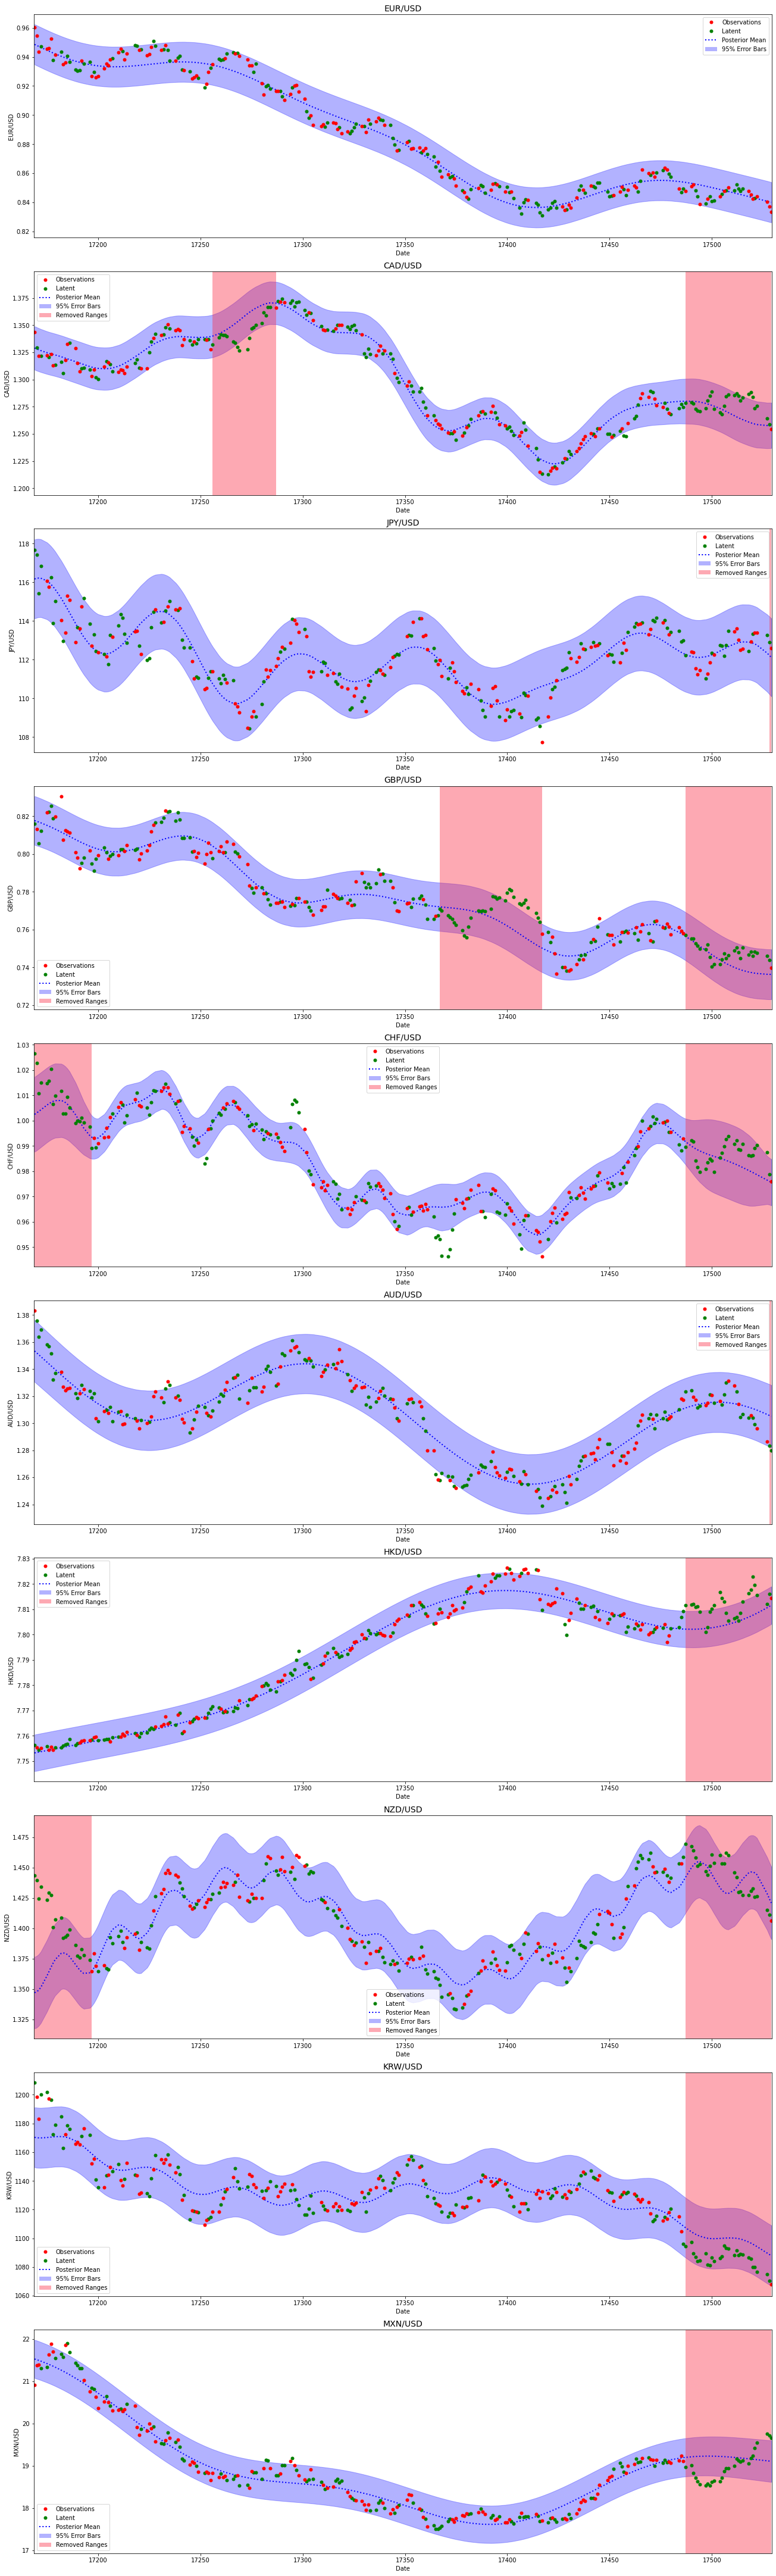

In [8]:
best_mosm = mosm_models[np.argmin(mosm_mape.mean(1))]
best_mosm.predict()
best_mosm.plot_prediction();

## Cross spectral mixture kernel

In [9]:
csm_models = []
csm_mae = np.zeros((n_trials,10))
csm_rmse = np.zeros((n_trials,10))
csm_mape = np.zeros((n_trials,10))

for n in range(n_trials):
    csm_dataset = dataset.copy()
    for i, channel in enumerate(csm_dataset):
        channel.remove_randomly(pct=0.3)
        
    print('\nTrial', n+1, 'of', n_trials)
    csm = mogptk.CSM(csm_dataset, Q=Q)
    csm.init_parameters(init_method)    
    csm.train(method=method, lr=lr, iters=iters, verbose=True)
    csm_models.append(csm)
    print('=' * 50)
    
    error = mogptk.error(csm, per_channel=True)[0]
    csm_mae[n,:] = np.array([item['MAE'] for item in error])
    csm_rmse[n,:] = np.array([item['RMSE'] for item in error])
    csm_mape[n,:] = np.array([item['MAPE'] for item in error])


Trial 1 of 3

Starting optimization using Adam
‣ Model: CSM
‣ Channels: 10
‣ Parameters: 76
‣ Training points: 1080
‣ Initial loss: 1104.66

Start Adam:
    0/500   0:00:01  loss=     1104.66
    5/500   0:00:07  loss=     967.154
   10/500   0:00:13  loss=     875.214
   15/500   0:00:18  loss=     777.076
   20/500   0:00:23  loss=     684.597
   25/500   0:00:29  loss=     597.686
   30/500   0:00:34  loss=     513.449
   35/500   0:00:39  loss=     435.087
   40/500   0:00:45  loss=     362.404
   45/500   0:00:50  loss=     296.356
   50/500   0:00:56  loss=     237.544
   55/500   0:01:01  loss=     187.677
   60/500   0:01:07  loss=     150.239
   65/500   0:01:12  loss=     107.381
   70/500   0:01:17  loss=     77.5491
   75/500   0:01:22  loss=     45.2565
   80/500   0:01:28  loss=     27.1807
   85/500   0:01:33  loss=     20.0989
   90/500   0:01:39  loss=    0.386542
   95/500   0:01:44  loss=    -24.4887
  100/500   0:01:49  loss=    -35.5421
  105/500   0:01:55  loss= 

  490/500   0:08:48  loss=    -238.371
  495/500   0:08:53  loss=    -246.441
  500/500   0:08:59  loss=    -252.729
Finished

Optimization finished in 8 minutes 59 seconds
‣ Iterations: 500
‣ Final loss: -252.729

Trial 3 of 3

Starting optimization using Adam
‣ Model: CSM
‣ Channels: 10
‣ Parameters: 76
‣ Training points: 1093
‣ Initial loss: 1120.56

Start Adam:
    0/500   0:00:01  loss=     1120.56
    5/500   0:00:06  loss=     984.519
   10/500   0:00:11  loss=     881.915
   15/500   0:00:17  loss=     788.589
   20/500   0:00:22  loss=     691.043
   25/500   0:00:27  loss=     600.375
   30/500   0:00:33  loss=     514.865
   35/500   0:00:38  loss=     433.917
   40/500   0:00:44  loss=     358.929
   45/500   0:00:49  loss=     295.498
   50/500   0:00:54  loss=     232.598
   55/500   0:01:00  loss=     179.408
   60/500   0:01:05  loss=     133.943
   65/500   0:01:11  loss=     102.069
   70/500   0:01:16  loss=     70.4565
   75/500   0:01:21  loss=     45.2425
   80/50

In [10]:
pd.DataFrame(np.c_[csm_mae.mean(1), csm_rmse.mean(1), csm_mape.mean(1),
             csm_mae.std(1), csm_rmse.std(1), csm_mape.std(1)],
             columns=['MAE', 'RMSE', 'MAPE', 'MAE std', 'RMSE std', 'MAPE std'])

,MAE,RMSE,MAPE,MAE std,RMSE std,MAPE std
0,0.599223,0.765870,0.627079,1.487277,1.879569,0.277313
1,1.180773,1.372929,0.707619,3.219390,3.675202,0.306940
2,1.194325,1.444053,0.754181,3.214573,3.857320,0.295204


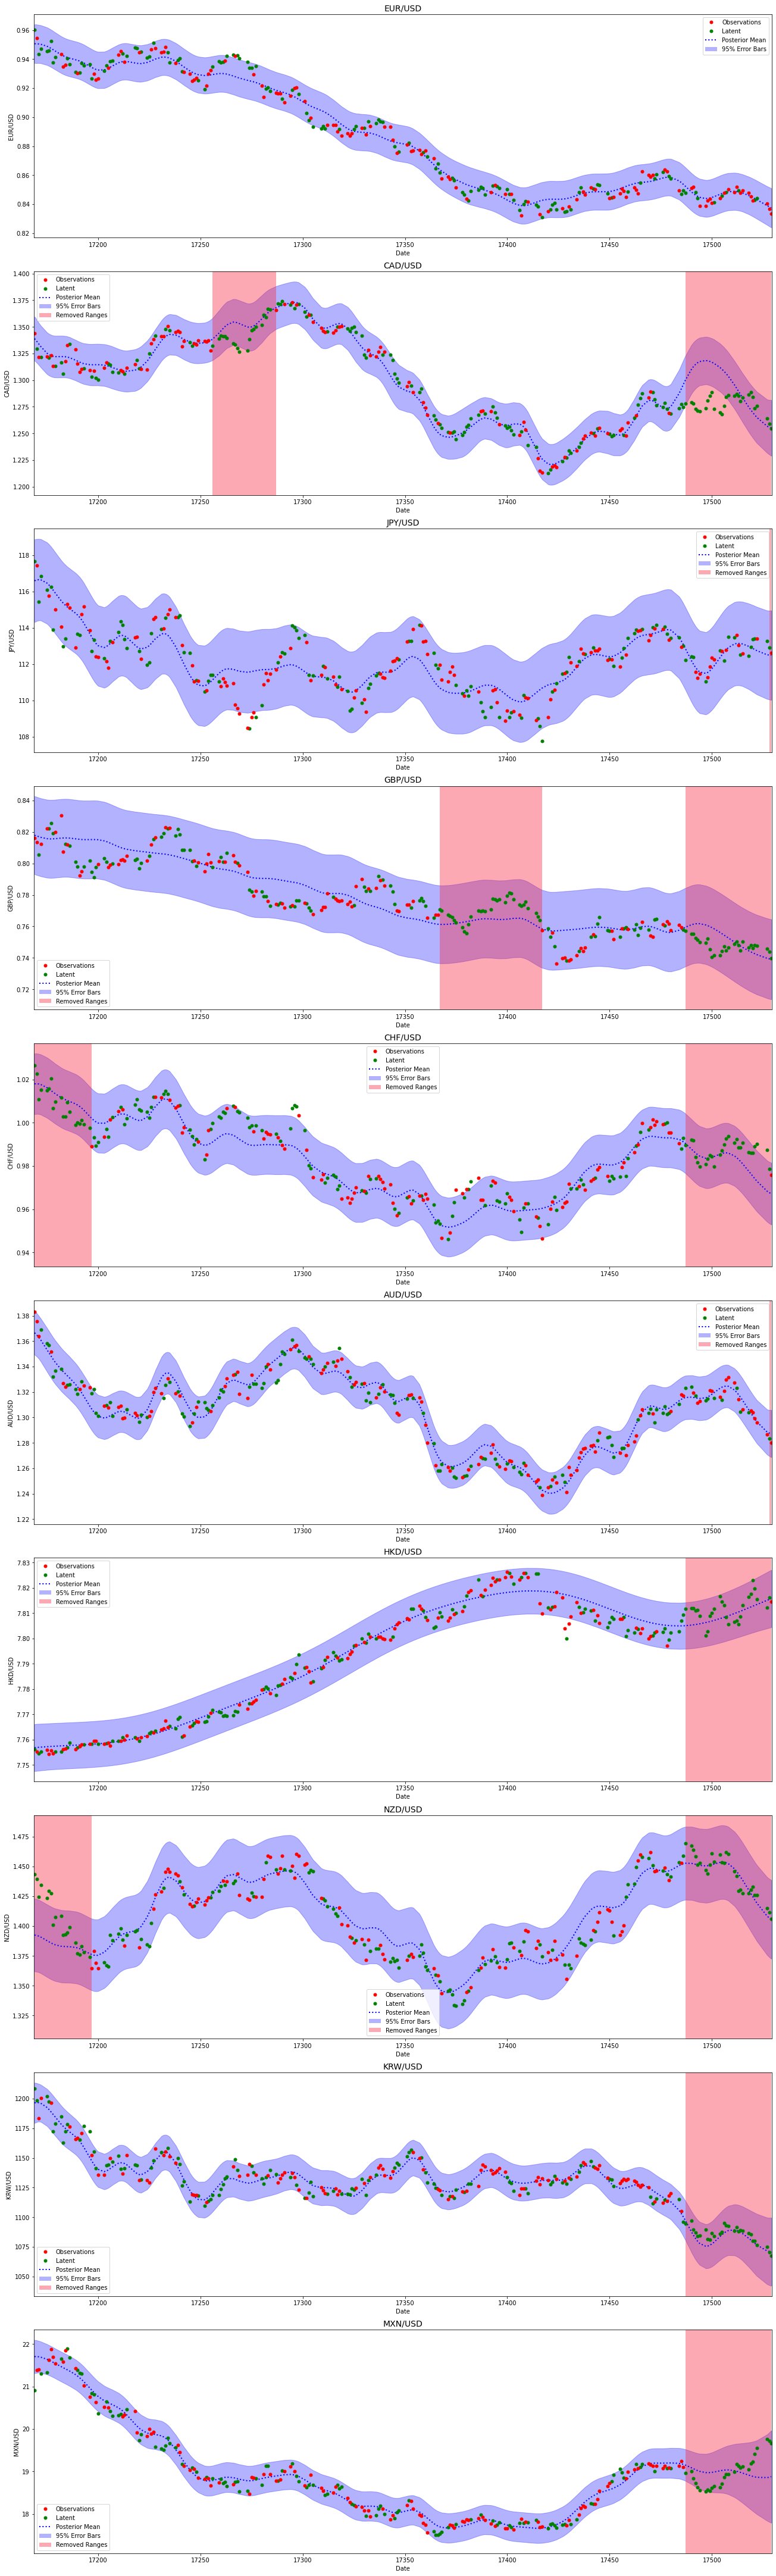

In [11]:
best_csm = csm_models[np.argmin(csm_mape.mean(1))]
best_csm.predict()
best_csm.plot_prediction();

## Linear model of coregionalization with spectral mixture kernels

In [12]:
smlmc_models = []
smlmc_mae = np.zeros((n_trials,10))
smlmc_rmse = np.zeros((n_trials,10))
smlmc_mape = np.zeros((n_trials,10))

for n in range(n_trials):
    smlmc_dataset = dataset.copy()
    for i, channel in enumerate(smlmc_dataset):
        channel.remove_randomly(pct=0.3)
        
    print('\nTrial', n+1, 'of', n_trials)
    smlmc = mogptk.SM_LMC(smlmc_dataset, Q=Q)
    smlmc.init_parameters(init_method)
    smlmc.train(method=method, lr=lr, iters=iters, verbose=True)
    smlmc_models.append(smlmc)
    print('=' * 50)

    error = mogptk.error(smlmc, per_channel=True)[0]
    smlmc_mae[n,:] = np.array([item['MAE'] for item in error])
    smlmc_rmse[n,:] = np.array([item['RMSE'] for item in error])
    smlmc_mape[n,:] = np.array([item['MAPE'] for item in error])


Trial 1 of 3

Starting optimization using Adam
‣ Model: SM-LMC
‣ Channels: 10
‣ Parameters: 46
‣ Training points: 1102
‣ Initial loss: 1127.37

Start Adam:
    0/500   0:00:00  loss=     1127.37
    5/500   0:00:03  loss=     1022.73
   10/500   0:00:06  loss=      931.47
   15/500   0:00:09  loss=     835.228
   20/500   0:00:11  loss=     749.111
   25/500   0:00:14  loss=      666.16
   30/500   0:00:17  loss=      588.59
   35/500   0:00:20  loss=     517.691
   40/500   0:00:23  loss=      453.26
   45/500   0:00:25  loss=     396.232
   50/500   0:00:28  loss=     346.554
   55/500   0:00:31  loss=     304.455
   60/500   0:00:34  loss=     270.139
   65/500   0:00:37  loss=     243.549
   70/500   0:00:40  loss=     223.488
   75/500   0:00:43  loss=     208.551
   80/500   0:00:46  loss=     198.032
   85/500   0:00:48  loss=     190.729
   90/500   0:00:51  loss=     185.635
   95/500   0:00:54  loss=     182.288
  100/500   0:00:57  loss=      179.37
  105/500   0:01:00  los

  490/500   0:04:29  loss=     129.088
  495/500   0:04:32  loss=     128.968
  500/500   0:04:35  loss=     128.856
Finished

Optimization finished in 4 minutes 35 seconds
‣ Iterations: 500
‣ Final loss: 128.856

Trial 3 of 3

Starting optimization using Adam
‣ Model: SM-LMC
‣ Channels: 10
‣ Parameters: 46
‣ Training points: 1079
‣ Initial loss: 1104.81

Start Adam:
    0/500   0:00:00  loss=     1104.81
    5/500   0:00:03  loss=     1003.53
   10/500   0:00:05  loss=     912.808
   15/500   0:00:08  loss=     822.026
   20/500   0:00:11  loss=     739.157
   25/500   0:00:14  loss=     663.403
   30/500   0:00:16  loss=     590.237
   35/500   0:00:19  loss=     521.726
   40/500   0:00:22  loss=     462.038
   45/500   0:00:25  loss=     411.304
   50/500   0:00:27  loss=     365.981
   55/500   0:00:30  loss=     327.793
   60/500   0:00:33  loss=     295.435
   65/500   0:00:36  loss=     267.946
   70/500   0:00:39  loss=     244.918
   75/500   0:00:41  loss=     225.768
   80/

In [13]:
pd.DataFrame(np.c_[smlmc_mae.mean(1), smlmc_rmse.mean(1), smlmc_mape.mean(1),
             smlmc_mae.std(1), smlmc_rmse.std(1), smlmc_mape.std(1)],
             columns=['MAE', 'RMSE', 'MAPE', 'MAE std', 'RMSE std', 'MAPE std'])

,MAE,RMSE,MAPE,MAE std,RMSE std,MAPE std
0,1.300352,1.651520,0.906478,3.447964,4.384061,0.311815
1,1.151461,1.412515,0.862733,3.057899,3.718161,0.277745
2,1.312147,1.558453,0.711142,3.574198,4.228392,0.299729


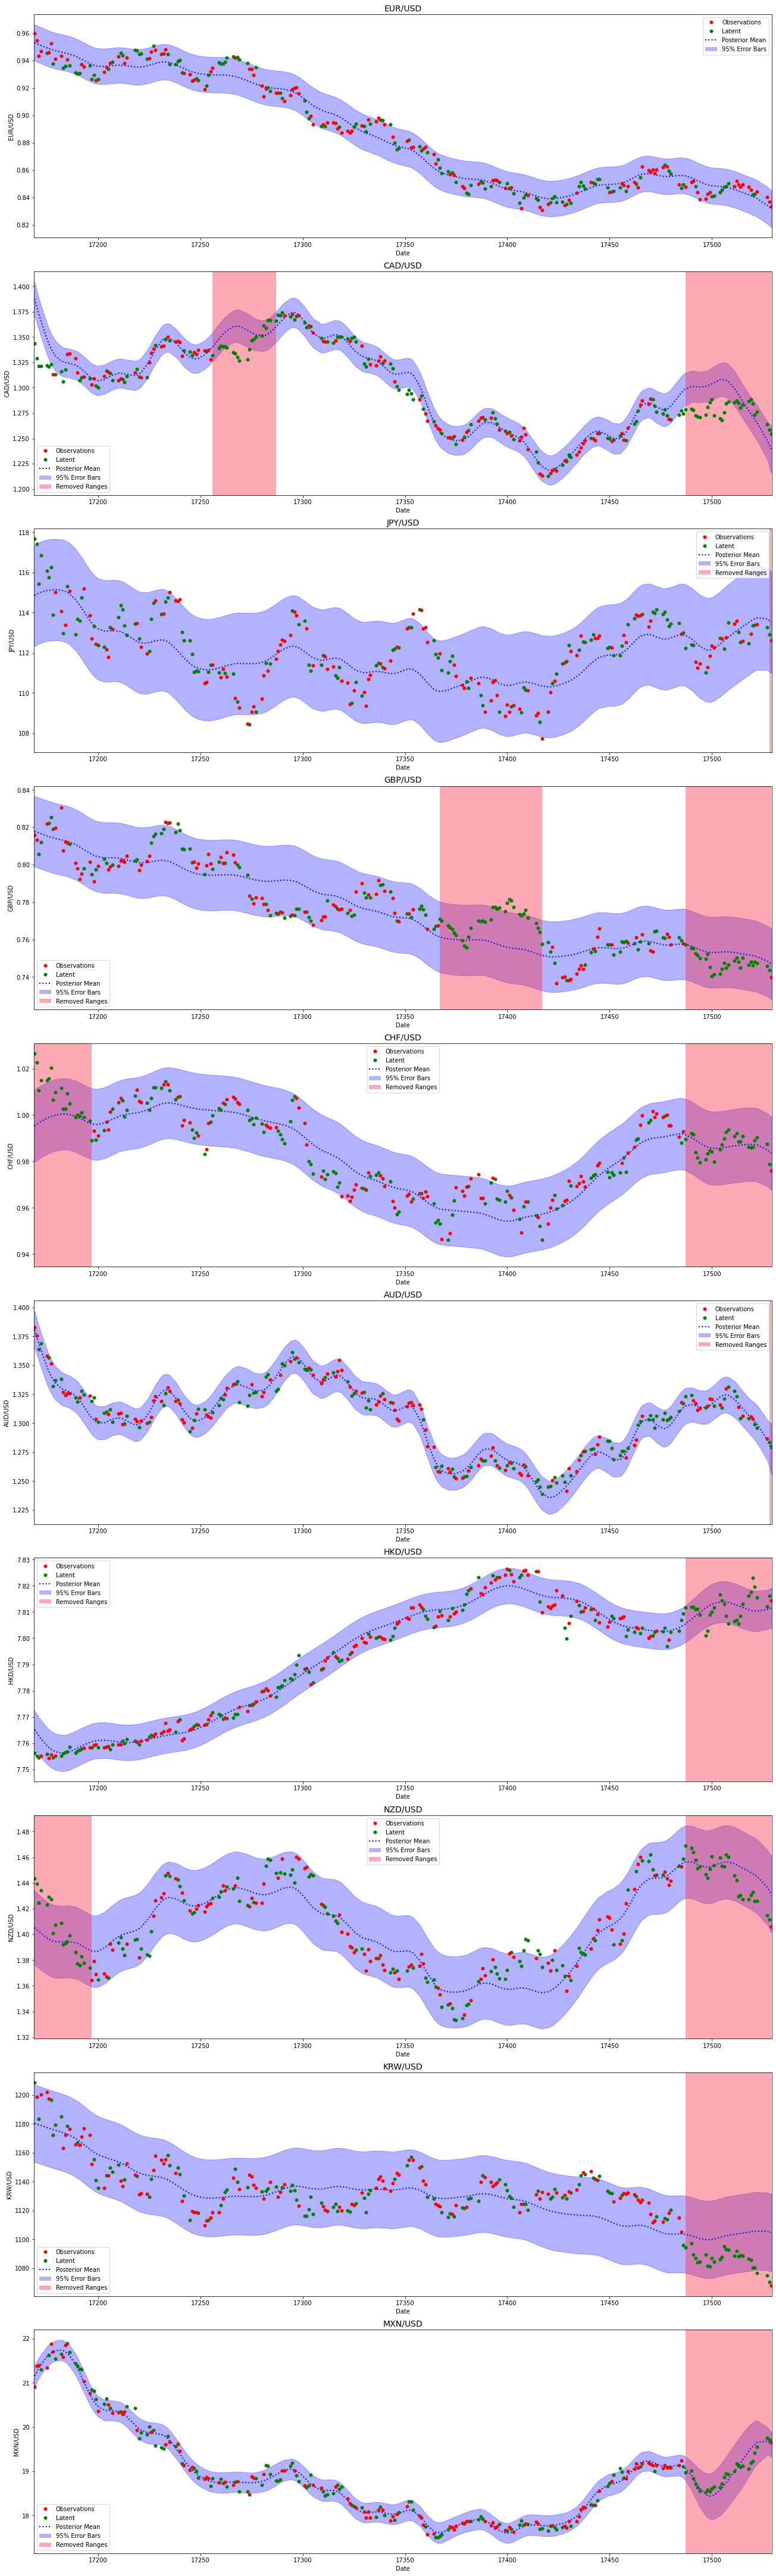

In [14]:
best_smlmc = smlmc_models[np.argmin(smlmc_mape.mean(1))]
best_smlmc.predict()
best_smlmc.plot_prediction();

## Independent spectral mixture kernels

In [15]:
sm_models = []
sm_mae = np.zeros((n_trials,10))
sm_rmse = np.zeros((n_trials,10))
sm_mape = np.zeros((n_trials,10))

for n in range(n_trials):
    sm_dataset = dataset.copy()
    for i, channel in enumerate(sm_dataset):
        channel.remove_randomly(pct=0.3)
    
    print('\nTrial', n+1, 'of', n_trials)
    sm = mogptk.SM(sm_dataset, Q=Q)
    sm.init_parameters(init_method)
    sm.train(method=method, lr=lr, iters=iters, verbose=True)
    sm_models.append(sm)
    print('=' * 50)
        
    error = mogptk.error(sm, per_channel=True)[0]
    sm_mae[n,:] = np.array([item['MAE'] for item in error])
    sm_rmse[n,:] = np.array([item['RMSE'] for item in error])
    sm_mape[n,:] = np.array([item['MAPE'] for item in error])


Trial 1 of 3

Starting optimization using Adam
‣ Model: SM
‣ Channels: 10
‣ Parameters: 100
‣ Training points: 1081
‣ Initial loss: 1091.95

Start Adam:
    0/500   0:00:00  loss=     1091.95
    5/500   0:00:02  loss=     990.352
   10/500   0:00:04  loss=     894.648
   15/500   0:00:06  loss=     799.661
   20/500   0:00:08  loss=     708.003
   25/500   0:00:10  loss=     617.989
   30/500   0:00:12  loss=     530.441
   35/500   0:00:15  loss=     446.143
   40/500   0:00:17  loss=      365.64
   45/500   0:00:19  loss=     289.013
   50/500   0:00:21  loss=     216.623
   55/500   0:00:23  loss=     150.409
   60/500   0:00:25  loss=     91.1761
   65/500   0:00:27  loss=     39.0437
   70/500   0:00:30  loss=    -7.55423
   75/500   0:00:32  loss=    -49.7618
   80/500   0:00:34  loss=    -82.4165
   85/500   0:00:36  loss=    -110.847
   90/500   0:00:38  loss=    -131.547
   95/500   0:00:40  loss=    -147.092
  100/500   0:00:42  loss=    -157.296
  105/500   0:00:44  loss= 

  490/500   0:03:41  loss=    -318.274
  495/500   0:03:43  loss=    -318.241
  500/500   0:03:45  loss=    -318.128
Finished

Optimization finished in 3 minutes 45 seconds
‣ Iterations: 500
‣ Final loss: -318.128

Trial 3 of 3

Starting optimization using Adam
‣ Model: SM
‣ Channels: 10
‣ Parameters: 100
‣ Training points: 1086
‣ Initial loss: 1095.58

Start Adam:
    0/500   0:00:00  loss=     1095.58
    5/500   0:00:02  loss=     994.364
   10/500   0:00:04  loss=     897.103
   15/500   0:00:07  loss=     802.113
   20/500   0:00:09  loss=     709.339
   25/500   0:00:11  loss=     618.273
   30/500   0:00:13  loss=     530.009
   35/500   0:00:15  loss=     444.738
   40/500   0:00:18  loss=     363.362
   45/500   0:00:20  loss=     284.074
   50/500   0:00:22  loss=     211.048
   55/500   0:00:24  loss=     142.124
   60/500   0:00:26  loss=     80.6439
   65/500   0:00:29  loss=     25.7677
   70/500   0:00:31  loss=    -22.8297
   75/500   0:00:33  loss=    -64.0164
   80/50

In [16]:
pd.DataFrame(np.c_[sm_mae.mean(1), sm_rmse.mean(1), sm_mape.mean(1),
             sm_mae.std(1), sm_rmse.std(1), sm_mape.std(1)],
             columns=['MAE', 'RMSE', 'MAPE', 'MAE std', 'RMSE std', 'MAPE std'])

,MAE,RMSE,MAPE,MAE std,RMSE std,MAPE std
0,0.926913,1.233118,0.709221,2.539383,3.378007,0.316391
1,1.036391,1.336773,0.636743,2.897598,3.732074,0.289083
2,0.896370,1.203064,0.734213,2.431880,3.280786,0.347998


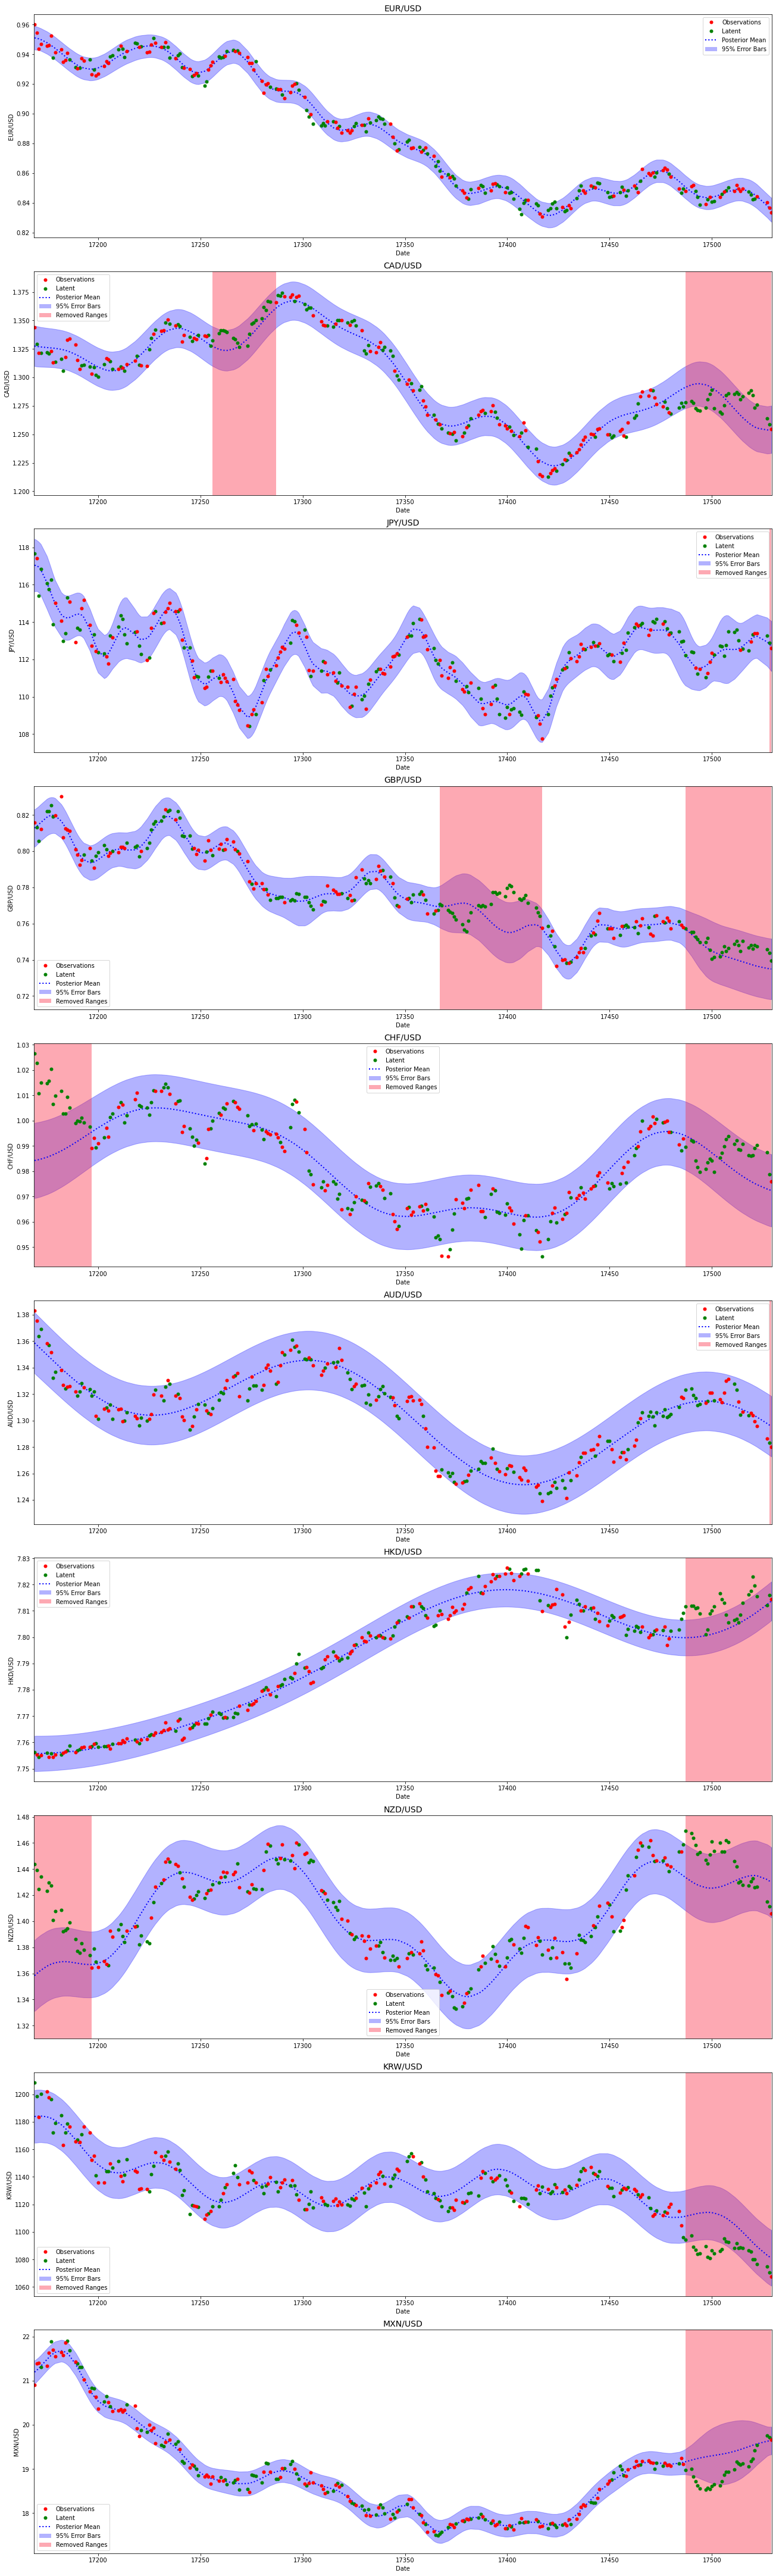

In [17]:
best_sm = sm_models[np.argmin(sm_mape.mean(1))]
best_sm.predict()
best_sm.plot_prediction();

## Results

In [18]:
print('MAPE errors per model')
print('MOSM:    %g ± %g' % (mosm_mape.mean(1).mean(), mosm_mape.mean(1).std()))
print('CSM:     %g ± %g' % (csm_mape.mean(1).mean(), csm_mape.mean(1).std()))
print('SM-LMC:  %g ± %g' % (smlmc_mape.mean(1).mean(), smlmc_mape.mean(1).std()))
print('SM:      %g ± %g' % (sm_mape.mean(1).mean(), sm_mape.mean(1).std()))

MAPE errors per model
MOSM:    0.745688 ± 0.0192832
CSM:     0.696293 ± 0.0525037
SM-LMC:  0.826785 ± 0.083699
SM:      0.693392 ± 0.041336
